# scikit-learn

## Overview

Scikit-learn [R] is a Python package containing a wide selection of tools for machine learning. Machine learning is a technique of using computers to make predtictions on unseen data based on either previously seen data or algorithms which find patterns within data. In addition to a large collection of data analysis algorithms, the package also provides tools for data preprocessing and dimensionality reduction; model selection and hyperparameter tuning - that is, finding an algorithm and a set of parameters to that algorithm that enable it to best perform on a particular dataset.


In [111]:
# imports
import pandas as pd
import os
import requests
from urllib.parse import urljoin
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sklearn.model_selection as mod
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score



## The Wine Quality Dataset
The wine quality dataset, available from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/), consists of two semicolon-delimited files, one relating to Portuguese *Vinho Verde* red wines and one to whites. The datasets were produced by Cortez et al. [R] in order to assess various machine learning algorithms in prediction of the quality of a wine from its properties. They considered support vector machines, multiple regression analysis, and neural networks. Of these the best performance was achieved using SVM [RPaper,RDatasheet].

Twelve attributes are recorded for each wine sample; eleven are objective physical or chemical attributes, and one, `quality`, is a subjective assessment of the wine's quality. The `quality` attribute is recorded as a value from 0 (poorest quality) to 10 (best quality) and is derived from the median score assigned to it by at least three experts [RDatasheet].

The data information sheet distributed with the data [R] notes that several attributes may be correlated and that not all attributes necessarily affect quality and suggests that feature selection may be advisable. The datasheet also suggests that the problem of wine quality prediction may be cast as a regression problem or as a classification problem.


### Downloading the dataset
The dataset is downloaded as two semicolon delimited files from the UCI Machine Learning Repository and saved to disc.

In [2]:
# Location of wine quality dataset
base_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/'
# Local data directory
data_dir = 'data/wine/'

# Names of dataset files to be downloaded
source_files = ('winequality-red.csv', 'winequality-white.csv', 'winequality.names')

# for each of the source files construct url, 
# fetch file, and write to data directory
for datafile in (source_files):
    response = requests.get(urljoin(base_url, datafile))
    with open(os.path.join(data_dir, datafile), 'wb') as f:
        f.write(response.content)

In [60]:
# Load red wine and white wine datasets into pandas DataFrames
rw = pd.read_csv('data/wine/winequality-red.csv', delimiter=";")
ww = pd.read_csv('data/wine/winequality-white.csv', delimiter=";")

## Exploring the dataset and selecting features

In [3]:
# See the first few records of the red wine dataset
rw.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


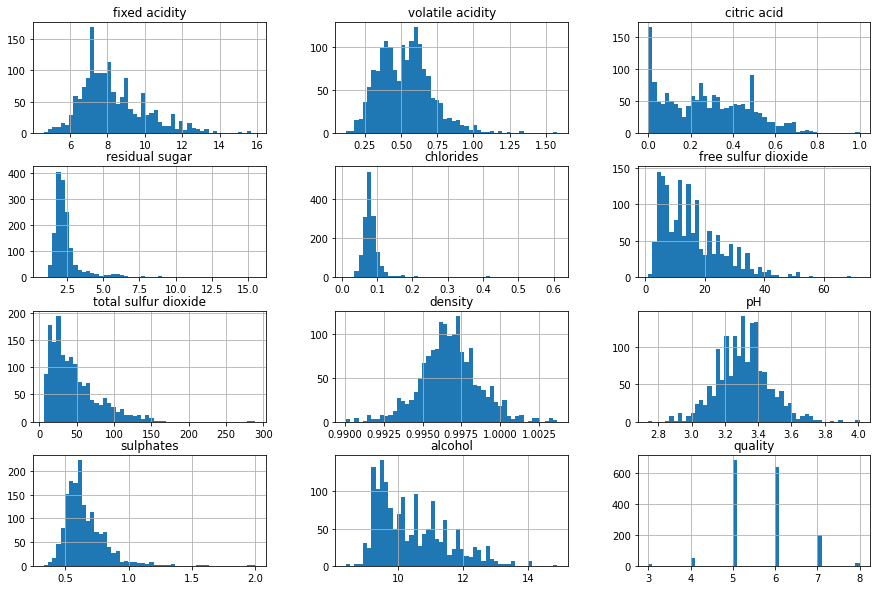

In [4]:
hist = rw.hist(bins=50, figsize=(15, 10))
plt.show()

In [79]:
rw['quality_cat'] = np.where(rw['quality'] <= 4, 'low', np.where(rw['quality'] >= 7, 'high', 'medium'))

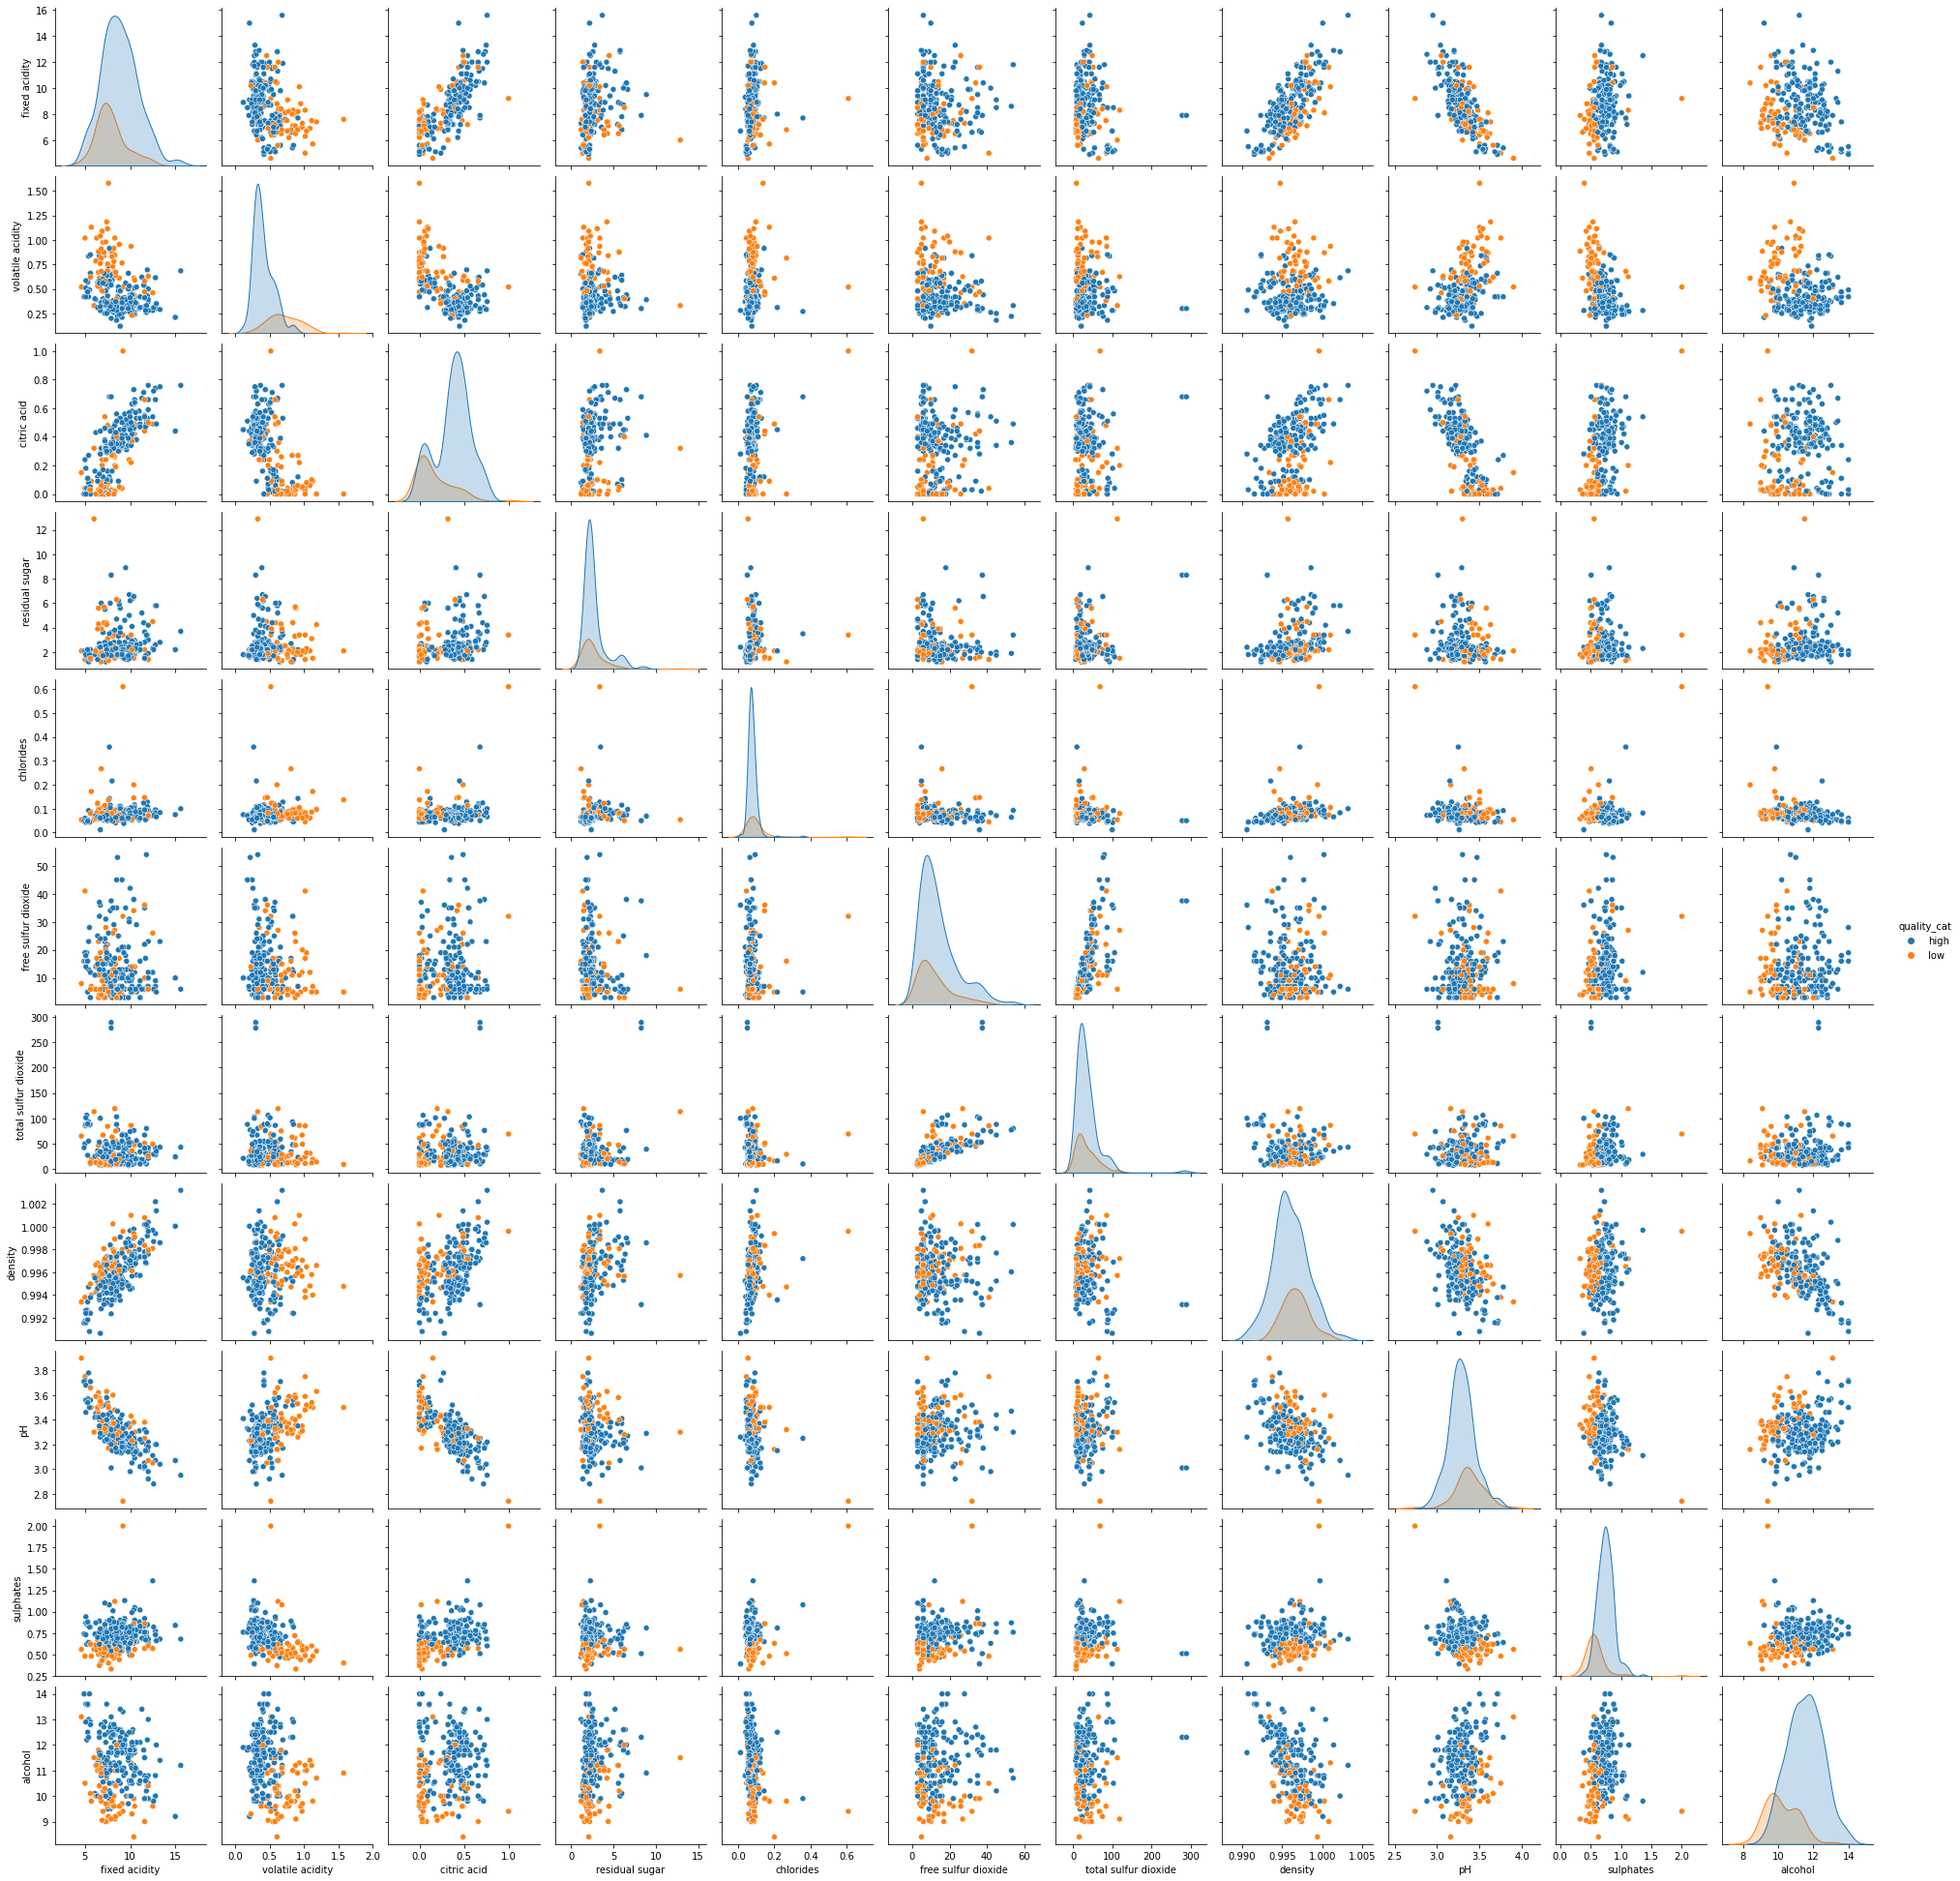

In [18]:
sns.pairplot(rw[rw['quality_cat'].isin(['low','high'])].drop('quality', axis=1), hue='quality_cat')

In [57]:
#rw=rw.drop(['quality_cat'], axis=1)

In [20]:
corr = rw.corr()
corr

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.124052
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.390558
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.226373
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,0.013732
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.128907
free sulfur dioxide,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408,-0.050656
total sulfur dioxide,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654,-0.185100
density,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180,-0.174919
pH,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633,-0.057731
sulphates,0.183006,-0.260987,0.312770,0.005527,0.371260,0.051658,0.042947,0.148506,-0.196648,1.000000,0.093595,0.251397


<AxesSubplot:>

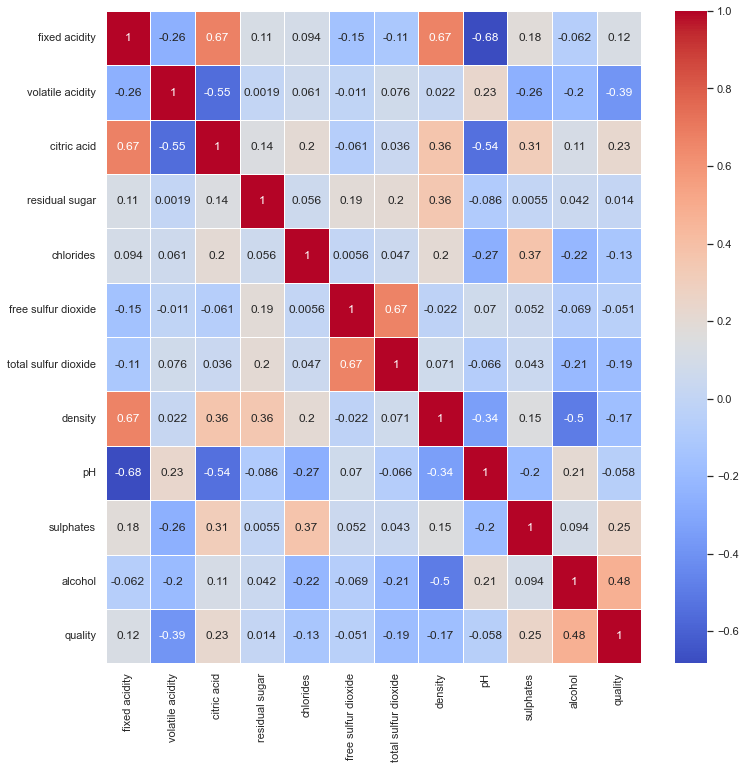

In [29]:
sns.set(rc={'figure.figsize':(12,12)})
sns.heatmap(corr, annot=True, linewidths=0.5, cmap='coolwarm')

`Fixed acidity` is correlated with `citric acid`, `density`, and `pH`
`citric acid` also has a fairly strong correlation with `volatile acidity` and `pH`
`density` has a correlation of 0.5 with `alcohol`
`total sulfur dioxide` and `free sulfur dioxide` are highly correlated
It seems that perhaps `citric acid`, `density`, `pH`, and `free sulfur dioxide` could be dropped.

Correlation with `quality` shows which attributes have the strongest influence on the output variable. It would be instructive to examine that individually. First we look at the features we propose to keep:

In [34]:
# Sort values in the correlation matrix by the absolute correlation value
abs(corr['quality'].drop(['quality', 'citric acid', 'density', 'pH', 'free sulfur dioxide'])).sort_values(ascending=False)

IndentationError: unexpected indent (3199008622.py, line 4)

`residual sugar` seems to have a negligible influence on quality. We'll try dropping that too for now.

In [35]:
# Double check correlations between dropped features and quality
abs(corr['quality'].drop(['quality', 'alcohol', 'volatile acidity', 'sulphates', 'total sulfur dioxide', 'chlorides', 'fixed acidity', 'residual sugar'])).sort_values(ascending=False)

citric acid            0.226373
density                0.174919
pH                     0.057731
free sulfur dioxide    0.050656
Name: quality, dtype: float64

In [80]:
# Drop some features
rwd = rw.drop(['citric acid', 'density', 'pH', 'free sulfur dioxide', 'residual sugar'], axis=1)

In [44]:
rwd.head()

,fixed acidity,volatile acidity,chlorides,total sulfur dioxide,sulphates,alcohol,quality
0,7.4,0.70,0.076,34.0,0.56,9.4,5
1,7.8,0.88,0.098,67.0,0.68,9.8,5
2,7.8,0.76,0.092,54.0,0.65,9.8,5
3,11.2,0.28,0.075,60.0,0.58,9.8,6
4,7.4,0.70,0.076,34.0,0.56,9.4,5


## Preprocessing the data


In [108]:
train, test = mod.train_test_split(rwd.drop(['quality'], axis=1))

In [109]:
X, y = train.drop(['quality_cat'], axis=1), train['quality_cat']
svm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5)),
])
svm_clf.fit(X,y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=1, kernel='poly'))])

In [110]:
svm_clf.score(test.drop(['quality_cat'], axis=1), test['quality_cat'])

0.8525

### Cross validation

In [114]:
scores = cross_val_score(svm_clf, X, y, cv=10)
print(scores)

[0.81666667 0.85       0.86666667 0.80833333 0.84166667 0.81666667
 0.81666667 0.80833333 0.84166667 0.89915966]


In [5]:
# See the first few records of the white wine dataset
ww.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
rw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [7]:
ww.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000,4898.000000
mean,6.854788,0.278241,0.334192,6.391415,0.045772,35.308085,138.360657,0.994027,3.188267,0.489847,10.514267,5.877909
std,0.843868,0.100795,0.121020,5.072058,0.021848,17.007137,42.498065,0.002991,0.151001,0.114126,1.230621,0.885639
min,3.800000,0.080000,0.000000,0.600000,0.009000,2.000000,9.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.300000,0.210000,0.270000,1.700000,0.036000,23.000000,108.000000,0.991723,3.090000,0.410000,9.500000,5.000000
50%,6.800000,0.260000,0.320000,5.200000,0.043000,34.000000,134.000000,0.993740,3.180000,0.470000,10.400000,6.000000
75%,7.300000,0.320000,0.390000,9.900000,0.050000,46.000000,167.000000,0.996100,3.280000,0.550000,11.400000,6.000000
max,14.200000,1.100000,1.660000,65.800000,0.346000,289.000000,440.000000,1.038980,3.820000,1.080000,14.200000,9.000000


## Algorithm demonstrations

### 1 Support Vector Machines

### 2 Decision Trees

### 3 Random Forests

## References

[1] Cortez, P., Cerdeira, A., Almeida, F., Matos, T., Reis, J., 2009, Modeling wine preferences by data mining from physicochemical properties, Decision Support Systems 47(4):547-553. doi:10.1016/j.dss.2009.05.016 

[2] Dua, D. and Graff, C. (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science

[3] Scikit-learn developers, https://scikit-learn.org/stable/modules/preprocessing.html
